# Introduction

Sepsis is a common disease which has become a global public health issue due to a relatively high prevalence and mortality rate.  Sepsis has an overall mortality rate of approximately 30% and is the cause of over 5.3 million annual deaths globally.  Sepsis is usually induced by an infection that has entered the bloodstream and can become an acute condition which results in life-threatening organ dysfunction.  Early identification and treatment of sepsis is essential for reducing the need for acute critical care and reducing the mortality rate of sepsis.  Improvements for treating sepsis could help to reduce the number of deaths related to sepsis as well as reduce the cost burden of treating sepsis on public finances.

Currently diagnosing sepsis relies on using serum markers or other laboratory tests to confirm sepsis.  However, by the time test for the biomarkers would be positive for sepsis the condition will have advanced to a more serious state and as a result it will be more difficult to successfully treat sepsis.  If a predictive model could be reasonably accurate in predicting if a patient is at risk of sepsis based on historical data rather than laboratory samples, that could have the potential to lead to earlier interventions based on the information in a patient's medical record.  If a predictive model could aid early intervention as oppossed to waiting for laboratory tests to confirm sepsis, that could potentially reduce the need for acute care and reduce the mortality rate associated with sepsis.

Best practices for diagnosing sepsis mostly rely on scoring systems that incorporate a relatively limited number of variables to produce a score that indicates the risk a patient has of developing sepsis. The scoring systems face challenges in predicting sepsis due to the fact that the scoring systems rely on a relatively limited number of predictor variables and also generally assume that the predictor variables are linearly related to the prediction of developing sepsis.  Additionally these scoring systems are relatively tedious to utilize since it usually requires clinicians to manually enter values into an application to calculate the score for a patient.  These shortcomings in addition to poor predictive strength, wide variances in predictive ranges and general operational difficulties have created an opportunity to apply predictive modeling to deliver improved predictive abilities and reduce the operational burden of utilizing the model.

Our paper proposed utilizing XGBoost for predicting the 30-day mortality of patients diagnosed with sepsis-3 based on the results of comparing SAPs-II scoring model, logistic regression and XGBoost.  Utilizing XGBoost would allow for clinicians to incorporate a wider range of data points about a patients medical history for predicting 30-day mortality due to sepsis.  The XGBoost model was able to achieve the highest ROC-AUC of 0.857 for predicting 30-day mortality.  The figure below shows the ROC-AUC results for each of the 3 models from the original paper.

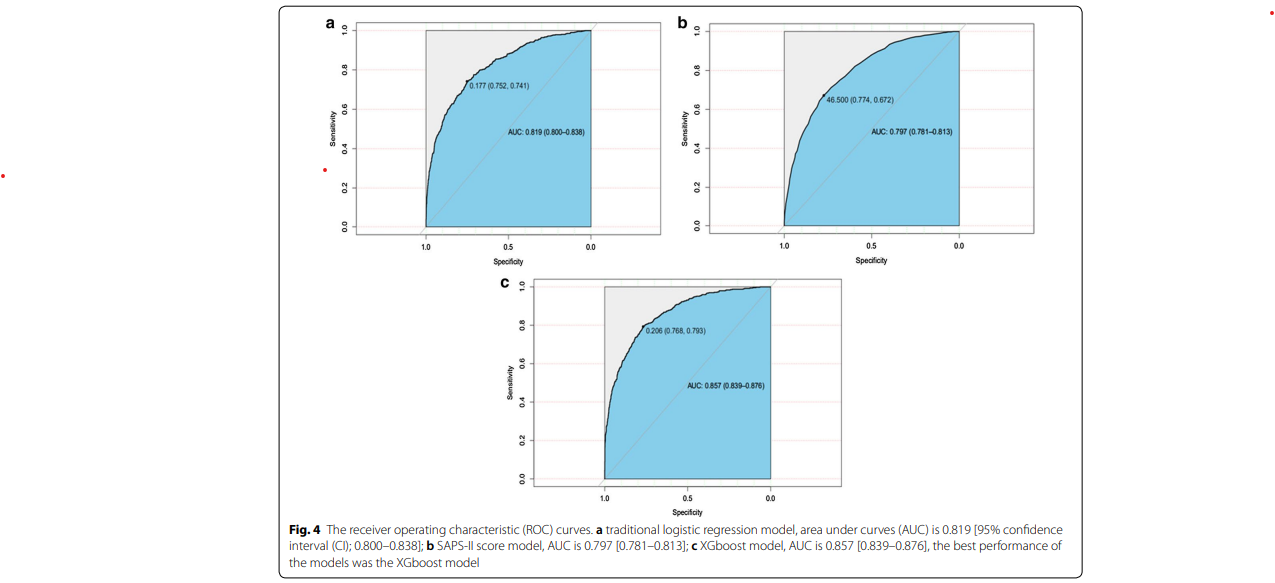



[LINK TO THE GITHUB](https://github.com/jamyooes/dlh_project/upload/main)

# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

**Hypothesis 1: The XGBoost model will exhibit superior predictive performance, as measured by AUC-ROC and DCA, compared to logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron, for 30-day mortality prediction in patients with sepsis-3.**

**Experiment 1: Train logistic regression, SAPS-II Score prediction model, XGBoost, and Multi-layer Perceptron on the MIMIC-III dataset for 30-day mortality prediction in patients with sepsis-3. Evaluate the models' performance using AUC-ROC and DCA.**

**Hypothesis 2: The XGBoost model will demonstrate enhanced clinical utility, reflected in its ability to provide actionable insights for precise management and therapy decisions for patients with sepsis-3, compared to logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron.**

**Experiment 2: Assess the clinical utility of the XGBoost model, logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron by evaluating their predictions in the context of clinical decision-making. Analyze the models' predictions to determine their impact on therapy decisions using clinical guidelines or expert opinions.**

In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can upload it to your google drive and show it with OpenCV or matplotlib
'''

# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [ ]:
# import  packages you need
import numpy as np
import pandas as pd
from google.colab import drive


##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: The authors' data was collected from the MIMIC III V1.4 Database from [https://physionet.org/content/mimiciii/1.4/](https://physionet.org/content/mimiciii/1.4/). They provided their raw dataset that they used for the models on their paper under the supplementary information: [Link](https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-020-02620-5#Sec14)
  

  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * Our raw dataset is uploaded to Google Drive

In [ ]:
"""
Access this link to get permissions to access the raw data
https://drive.google.com/drive/folders/1ymazaOWJkCV60WeyNgh3YW3Qxs7DqL1M?usp=sharing

If the path fails from below, then create a folder called raw_data_dlh and upload the file
to the folder. This raw dataset is publically available on the author's paper
and does not contain any information that will identify a patient.

The dataset can alternatively be access on the author's website.
There is no private information in the shared drive or in our personal illinois.edu
drive, there is simply a pdf file in the folder above
"""

In [ ]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dir and function to load raw data
data_path = '/content/drive/MyDrive/raw_data_dlh/12967_2020_2620_MOESM1_ESM.csv'

def load_raw_data(raw_data_dir):
  """
  Data has been preprocess by the authors of the paper
  Load the data as a dataframe
  """
  data_df = pd.read_csv(data_path)
  return data_df

raw_data = load_raw_data(data_path)

def calculate_stats(raw_data):
  """
  Calculate the Statistics of the dataset

  This function takes in the raw_data and displays the basic statistics like
  the size of the dataset and the label distribution

  TODO - MORE STATS
  """
  survivors = len(raw_data[raw_data["thirtyday_expire_flag"] == 0])
  deceased = len(raw_data[raw_data["thirtyday_expire_flag"] == 1])
  print(f"There are {len(raw_data)} patient data used for training")
  print(f"The shape of the dataset is {raw_data.shape}")
  print(f"The distribution of the data is {survivors} survivors and {deceased} deceased patients")
  print(f"{survivors/len(raw_data) * 100}% are survivors and {deceased/len(raw_data) * 100}% are deceased")
  return None


def process_data(raw_data, lr_feats, xgb_feats):
  """
  Data cleaning the data is not needed as the authors have provided their raw
  dataset on their paper.

  Class labels is the thirtyday_expire_flag, which denotes whether the patient has passed away or lived.

  There is some scaling for the raw_data and imputation on the data

  Input data is the raw data, the logistic regression features, and the xgboost features

  Output will be the train and test splits for the models - LR, XGBoost, SAPS model, and the MLP Model.

  This function will split the dataset into train and test splits
  """
  # Filter columns for the traditional models
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  import torch
  from sklearn.impute import SimpleImputer
  # Feature and target
  logistic_feats = raw_data[lr_feats[:-1]]
  logistic_target = raw_data[lr_feats[-1]]

  # Train and Test splits
  X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(logistic_feats, logistic_target,
                                                                  test_size = 0.2, stratify = logistic_target, random_state = 42)
  # Standardize the features for the traditonal models
  lr_scaler = StandardScaler()
  X_train_lr = lr_scaler.fit_transform(X_train_lr)
  X_test_lr = lr_scaler.transform(X_test_lr)

  lr_imputer = SimpleImputer(strategy = 'mean')
  X_train_lr = lr_imputer.fit_transform(X_train_lr)
  X_test_lr = lr_imputer.transform(X_test_lr)



  """
  TO DO - ADD DATALOADERS FOR THE Deep learning model(MLP) and set up XGBOOST, AND FOR SAPSII
  """


  return [X_train_lr, X_test_lr, y_train_lr, y_test_lr]

# These are the features used in the models from the paper
logistic_regression_features = ["sofa", "aniongap_min", "creatinine_min", "chloride_min",
                                "hematocrit_min", "hemoglobin_min", "hemoglobin_max",
                                "lactate_min", "potassium_min", "sodium_max",
                                "bun_min", "bun_max", "wbc_min", "wbc_max", "heartrate_min",
                                "heartrate_mean", "sysbp_min", "meanbp_min", "resprate_mean",
                                "tempc_min", "tempc_max", "spo2_mean", "age", "diabetes",
                                "vent", "thirtyday_expire_flag"]
x_g_boost_features = ["urineoutput", "lactate_min", "bun_mean", "sysbp_min", "metastatic_cancer",
                      "inr_max", "age", "sodium_max", "aniongap_max", "creatinine_min", "spo2_mean",
                      "thirtyday_expire_flag"]
lr_data_list = process_data(raw_data, logistic_regression_features, x_g_boost_features)

calculate_stats(raw_data)

There are 4559 patient data used for training
The shape of the dataset is (4559, 106)
The distribution of the data is 3670 survivors and 889 deceased patients
80.50010967317394% are survivors and 19.49989032682606% are deceased


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

  The paper does not use epochs or layers as the models are Logistic Regression, XGBoost, and SAPS-II Model

In [ ]:
# Logistic Regression Model and Training
# This model is relatively simple and is the point of comparison to the other models according to the paper
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training Logistic Regression
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(lr_data_list[0], lr_data_list[2])

# Hyperparameter tuning - We were not sure if the paper used hyperparameter tuning as it wasn't specified, so we decided to include this as well for comparison
# Given that the results don't look too great we are planning to look deeper
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 50, 100]}
lr_cv = GridSearchCV(LogisticRegression(random_state = 42), param_grid, cv = 10, scoring = 'precision')
lr_cv.fit(lr_data_list[0], lr_data_list[2])

# Training Logistic Regression
best_lr_model = lr_cv.best_estimator_

In [ ]:
# SAPS-II Scoring System for calculting 30-day mortality for ICU patients

def saps_II(df):
    '''
    Based on criteria of SAPS-II methodology assign risk value for each criteria
    Use summed risk score to calculate percentage risk of 30-day mortality
    https://www.mdcalc.com/calc/4044/simplified-acute-physiology-score-saps-ii#next-steps
    '''
    # Age criteria
    age_criteria = [
        (df['age'].lt(40)),
        (df['age'].ge(40) & df['age'].lt(60)),
        (df['age'].ge(60) & df['age'].lt(69)),
        (df['age'].ge(70) & df['age'].lt(75)),
        (df['age'].ge(75) & df['age'].lt(80)),
        (df['age'].ge(80))
        ]

    age_value = [0, 7, 12, 15, 16, 18]

    df['saps_age'] = np.select(age_criteria, age_value)
    #check_age = df[['age', 'saps_age']]


    # Heart Rate Criteria
    hr_criteria = [
        (df['heartrate_min'].lt(40)),
        (df['heartrate_min'].ge(40)  & df['heartrate_min'].lt(70)),
        (df['heartrate_min'].ge(70)  & df['heartrate_min'].lt(120)),
        (df['heartrate_min'].ge(120) & df['heartrate_min'].lt(160)),
        (df['heartrate_min'].ge(160))
        ]

    hr_value = [11, 2, 0, 4, 7]

    df['saps_heartrate'] = np.select(hr_criteria, hr_value)
    #check_hr = df[['heartrate_min', 'saps_heartrate']]


    # Systolic BP
    sysbp_criteria = [
        (df['sysbp_min'].lt(70)),
        (df['sysbp_min'].ge(70) & df['sysbp_min'].lt(100)),
        (df['sysbp_min'].ge(100) & df['sysbp_min'].lt(200)),
        (df['sysbp_min'].ge(200))
        ]

    sysbp_value = [13, 5, 0, 2]

    df['saps_sysbp'] = np.select(sysbp_criteria, sysbp_value)
    #check_sysbp = df[['sysbp_min', 'saps_sysbp']]


    # Temperature
    temp_criteria = [
        (df['tempc_min'].ge(39))
        ]

    temp_value = [3]

    df['saps_temp'] = np.select(temp_criteria, temp_value)
    #check_temp = df[['tempc_min', 'saps_temp']]


    # GCS - Glasgow Coma Score, could not find score in data file
    # PaO2/FiO2 - cannot find data in file


    # BUN
    bun_criteria = [
        (df['bun_max'].lt(28)),
        (df['bun_max'].ge(28) & df['bun_max'].le(83)),
        (df['bun_max'].ge(84))
        ]

    bun_value = [0, 6, 10]

    df['saps_bun'] = np.select(bun_criteria, bun_value)
    #check_bun = df[['bun_max', 'saps_bun']]


    # Urine
    urine_criteria = [
        (df['urineoutput'].lt(500)),
        (df['urineoutput']. ge(500) & df['urineoutput'].lt(1000)),
        (df['urineoutput'].ge(1000))
        ]

    urine_value = [11, 4, 0]

    df['saps_urine'] = np.select(urine_criteria, urine_value)
    #check_urine = df[['urineoutput', 'saps_urine']]


    # Sodium
    sodium_criteria = [
        (df['sodium_min'].lt(125)),
        (df['sodium_min'].ge(125) & df['sodium_min'].lt(145)),
        (df['sodium_min'].ge(145))
        ]

    sodium_value = [5, 0, 1]

    df['saps_sodium'] = np.select(sodium_criteria, sodium_value)
    #check_sodium = df[['sodium_min', 'saps_sodium']]


    # Potassium
    potassium_criteria = [
        (df['potassium_min'].lt(3)),
        (df['potassium_max'].ge(5))
        ]

    potassium_value = [3, 3]

    df['saps_potassium'] = np.select(potassium_criteria, potassium_value)
    #check_potassium = df[['potassium_min', 'potassium_max', 'saps_potassium']]


    # Bicarbonate
    bicarb_criteria = [
        (df['bicarbonate_min'].lt(15)),
        (df['bicarbonate_min'].ge(15) & df['bicarbonate_min'].lt(20)),
        (df['bicarbonate_min'].ge(20))
        ]

    bicarb_value = [6, 3, 0]

    df['saps_bicarb'] = np.select(bicarb_criteria, bicarb_value)
    #check_bicarb = df[['bicarbonate_min', 'saps_bicarb']]


    # Bilirubin - did not see column in data file


    # WBC
    wbc_criteria = [
        (df['wbc_min'].lt(1)),
        (df['wbc_max'].ge(20))
        ]

    wbc_value = [12, 3]

    df['saps_wbc'] = np.select(wbc_criteria, wbc_value)
    #check_wbc = df[['wbc_min', 'wbc_max', 'saps_wbc']]


    # Chronic Disease
    chronic_criteria = [
        (df['metastatic_cancer'] == 1)
        ]

    chronic_value = [9]

    df['saps_chronic'] = np.select(chronic_criteria, chronic_value)
    #check_chronic = df[['metastatic_cancer', 'saps_chronic']]



    # List of columns created for calculating the score
    saps_columns = ['saps_age', 'saps_heartrate', 'saps_sysbp', 'saps_temp', 'saps_bun', 'saps_urine',
                    'saps_sodium', 'saps_potassium', 'saps_bicarb', 'saps_wbc', 'saps_chronic']

    # Calculate SAPS-II Score
    # 163 was referenced on wikipedia page for calculating %
    df['saps_II_score'] = df[saps_columns].sum(axis=1) / 163

    # Drop columns used to calculate final score
    df_out = df.drop(columns=saps_columns)

    return df_out


# Calculate SAPS-II score for each patient
df_sapsII = saps_II(raw_data)

In [ ]:
class my_model():
  # use this class to define your model
  pass

model = my_model()
loss_func = None
optimizer = None

def train_model_one_iter(model, loss_func, optimizer):
  pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
  train_model_one_iter(model, loss_func, optimizer)
  train_loss, valid_loss = None, None
  print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))


TypeError: must be real number, not NoneType

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


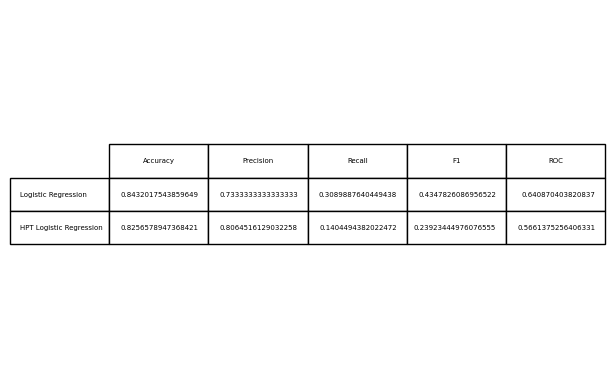

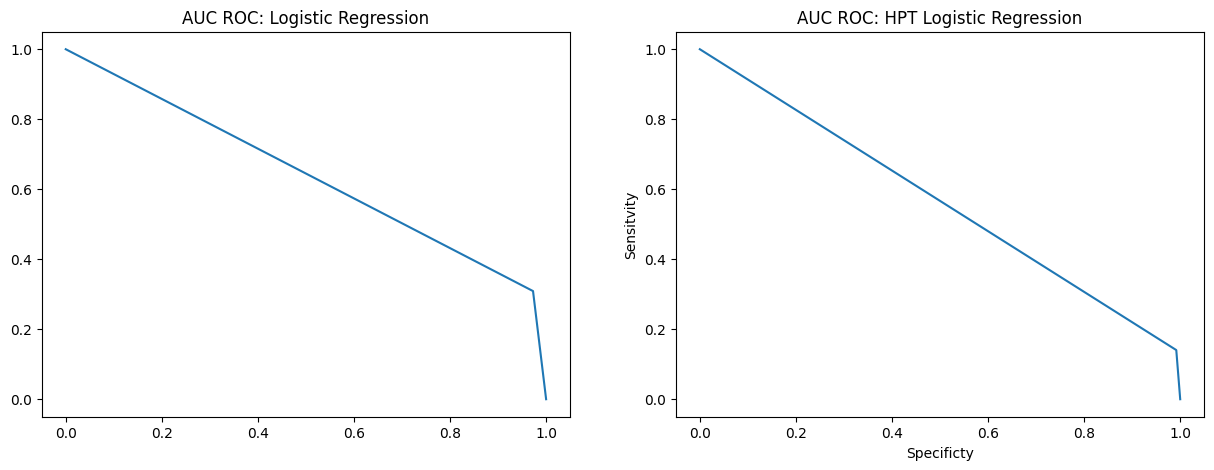

In [ ]:
# The graphs look a little weird compared to the paper
# Will need to look as to why this is the case as it is not "curving"

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_results = []
# metrics to evaluate my model
def calculate_stats(model, data):
  """
  Calculate Accuracy, Precision, Recall, and F1 Score
  """
  preds = model.predict(data[1])
  accuracy = accuracy_score(data[3], preds)
  precision = precision_score(data[3], preds)
  recall = recall_score(data[3], preds)
  f1 = f1_score(data[3], preds)
  fpr, tpr, thresholds = roc_curve(data[3], preds)
  roc_auc = auc(fpr, tpr)
  roc_results.append([fpr, tpr, roc_auc])

  data = [[accuracy, precision, recall, f1, roc_auc]]
  column_labels = ["Accuracy", "Precision", "Recall", "F1", "ROC"]
  results_df = pd.DataFrame(data, columns = column_labels)


  return results_df

def result_figures(results_df, model_type):
  # Set up table for results
  fig, ax = plt.subplots(1, 1)
  ax.axis('tight')
  ax.axis('off')

  results_table = ax.table(cellText = results_df.values,
                           colLabels = results_df.columns,
                           rowLabels = model_type,
                           loc = "center")
  results_table.set_fontsize(16)
  results_table.scale(1, 2)
  plt.show()

  fig, axes = plt.subplots(nrows=1, ncols=len(model_type), figsize=(15, 5))
  for i in range(len(roc_results)):
    ax = axes[i]
    ax.plot(1 - roc_results[i][0], roc_results[i][1])
    ax.set_title(f"AUC ROC: {model_type[i]}")
    plt.xlabel('Specificty')
    plt.ylabel('Sensitvity')
  pass


model_type_list = ["Logistic Regression", "HPT Logistic Regression"]
lr_results = calculate_stats(lr_model, lr_data_list)
hpt_lr_results = calculate_stats(best_lr_model, lr_data_list)
all_results = pd.DataFrame(pd.concat([lr_results, hpt_lr_results]).reset_index(drop = True))
result_figures(all_results, model_type_list)
# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

## Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''


# Thoughts on the Draft

The data part of the paper was the easiest part of the paper as the authors have provided their raw dataset used for the models. Incidently we spent the most time figuring out the data generation/cleaning of the data until we noticed that the author provided the dataset for their models publically on their paper.

The challenging part was trying to figure out the exact methodology the authors used for their models as there was no code provided. For example, we are not exactly too sure what strategy the authors used for missing data on 1 or 2 columns for a given row (i.e. imputation etc..) and we were not too familiar with their metrics.

Currently we are working towards figuring out how exactly the authors are creating their metrics and graphs as the Decision Curve Analysis on the three models, nomograms, and clinical impact curve for the xgboost model. We also planning on updating our Logistic Regression to attempt to reproduce their results and update our results/graphs to the metrics that the authors have used as our initial implementation for the LR model does not reproduce the same results on one of their metrics of AUC for ROC curves. This part is the main blocker at the moment.

We also plan to implement and test xgboost model and using the feature set idetified by the Boruta algorithm with MLP. We are familiar with both of the remaining model, so we are not too worried in implementation, but we implemented logistic regression to see if our results are similar to the paper's.

Timelines:
*   We plan to have the all our models implemented and tested by 4/21/2024. The computation is not too heavy given our dataset, so model training should not take up much time.

*   We also plan to complete the results/metrics concurrently and plan to have it done around the same time 4/24/2024.

*   We will spend additional time ~3 days until 4/27/2024 to optimize our models or if there's any bugs in our figure/results to try to reproduce the paper's results
*   Once we feel we reproduced the results or feel like we can't reproduce the results given the limitations we will create the video around 5/1/2024.



# References

1.   Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost., Journal of Translational Medicine, 2020, 18:462, doi: [https://doi.org/10.1186/s12967-020-02620-5](https://doi.org/10.1186/s12967-020-02620-5)
